In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import mlab
from scipy import stats
from itertools import permutations
from itertools import product

from matplotlib.dates import DateFormatter, MonthLocator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
import itertools
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/tomokitakata/dev/utilities/data/train.csv', encoding='utf-8')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# データ前処理

# 各種検定

## 定常性の検定

In [12]:
def stationality_check(data: pd.DataFrame) -> pd.DataFrame:
    ''''
    about:
    input: 
    output: 
    '''
    stationality_results = pd.DataFrame(columns = ['ADF static', 'p-value', '非定常の可能性'])
    data = data.dropna() # 欠損値があると検定できないのでdropnaする
    for col in data.columns: # カラムひとつづつ検査
        test_data = data[col]
        root_flag = ''
        result_adf = adfuller(test_data) # ADF検定
        if result_adf[1] >= 0.05: # 有意水準5%
            root_flag = '⚫︎'
        stationality_results.loc[col] = [result_adf[0], result_adf[1], root_flag]

    return stationality_results

# config
test = data[['Survived', 'Age']].dropna()
print(test)
stationality_check(test)

     Survived   Age
0           0  22.0
1           1  38.0
2           1  26.0
3           1  35.0
4           0  35.0
..        ...   ...
885         0  39.0
886         0  27.0
887         1  19.0
889         1  26.0
890         0  32.0

[714 rows x 2 columns]


,ADF static,p-value,非定常の可能性
Survived,-9.330417,9.361397e-16,
Age,-25.396731,0.000000e+00,


## 自己相関と偏自己相関の検定

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


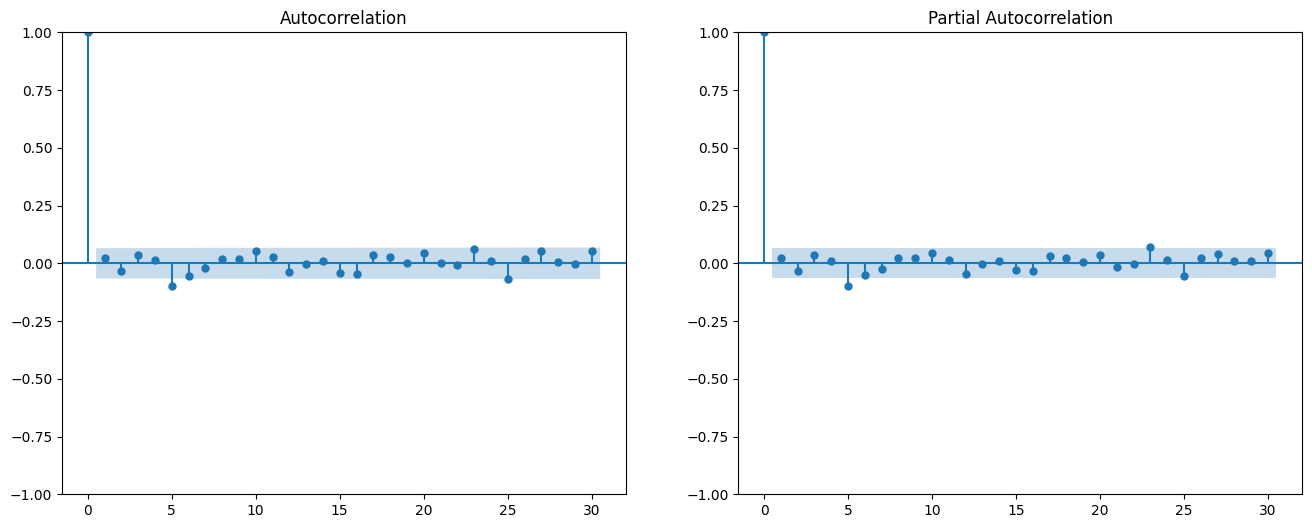

The lag with the smallest ACF value is 21 with a value of 0.0007705810597721047
The lag with the smallest PACF value is 13 with a value of -0.005178393492881361


In [13]:
def acf_pacf_check(target: pd.DataFrame, nlags: int):
    '''
    about:
    input: 
    output: 
    '''
    
    acf_values = acf(target, nlags)
    pacf_values = pacf(target, nlags)
    min_acf_lag = np.argmin(abs(acf_values))
    min_pacf_lag = np.argmin(abs(pacf_values))

    # ACFとPACFのプロット
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(target, ax=axes[0])
    plot_pacf(target, ax=axes[1])
    plt.show()

    print(f'The lag with the smallest ACF value is {min_acf_lag} with a value of {acf_values[min_acf_lag]}')
    print(f'The lag with the smallest PACF value is {min_pacf_lag} with a value of {pacf_values[min_pacf_lag]}')


# config
test = data.iloc[:,1]
print(test)
acf_pacf_check(test, 20)

# モデル構築

In [ ]:
# config
partition_date = '2022-06-30'

df_train = data[data.index <= partition_date]
df_test = data[data.index > partition_date]


endog_col = ['']
exog_col = ['']

train_len = len(df_train)
total_len = len(df)
window = 1
order = (11,0,3)
seasonal_order=(1,0,1,52)

df_pred = pd.DataFrame(index = df_test.index)